In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import itertools
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import sklearn as sk
#from mnist import MNIST
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode
import random


def label_with_delta(X,centers,delta): #give X (points) and centers: 2 numpy arrays
    labels = []
    count = 0 #to count the number of times we chose a random center
    for dist_array in pairwise_distances(X,centers): #dist_array is the array of distances between on element Xi of X and each cluster! 
        mindist = np.min(dist_array) #distance between Xi and its closest clusters
        normalmin = [np.argmin(dist_array)] # index of the clusters closest to Xi
        close_dist = set([dist for dist in dist_array if abs(dist-mindist)<delta]) #array of all distance of dist_array if they are delta-close to mindist 
        deltamin = [i for i, item in enumerate(dist_array) if item in close_dist] #index of delta-close centers 
        deltachoice = random.choice(deltamin) #choose randomly one of the delta-close centers
        labels.append(deltachoice)
        if deltamin!=normalmin:
            count+=1
    #print("DELTA K-MEANS: %d random choices of centers over %d"%(count,len(X)))
    return np.array(labels),count

def label_regular(X,centers):
    return pairwise_distances_argmin(X,centers)

def lossfunction(X,labels,centers):
    N = len(X)
    loss = 1/np.sqrt(N)*np.sum([np.linalg.norm(X[i]-centers[labels[i]]) for i in range(N)])
    return loss

### These are the functions to plot

In [2]:
def plot_delta_clusters(X,labels,random_choices,accuracy):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(231)
    ax1.set_title("Clusters")
    ax1.scatter(X[:, 0], X[:, 1], c=labels,
                s=5, cmap='viridis');
    ax2 = fig.add_subplot(232)
    ax2.set_title("Accuracy (%)")
    ax2.plot(accuracy, c='r') 
    ax3 = fig.add_subplot(233)
    ax3.set_title("Random choices of centers (delta)")
    ax3.plot(random_choices)  
    plt.show()
    
    
def plot_regular_clusters(X,labels,accuracy):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(231)
    ax1.set_title("Clusters")
    ax1.scatter(X[:, 0], X[:, 1], c=labels,
                s=5, cmap='viridis'); 
    ax2 = fig.add_subplot(232)
    ax2.set_title("Accuracy (%)")
    ax2.plot(accuracy, c='r')  
    plt.show()

### These are the two implementation of k-means

In [14]:
def find_clusters_regular(X, n_clusters, threshold, iterations=None):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i] 
    #variables to follow the kmeans
    step = 0
    loss = []
    accuracy = []
    
    
    while True:
        step+=1
        
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers) #REGULAR KMEANS
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        loss_step = lossfunction(X,labels,new_centers)
        loss.append(loss_step)
        
        labels_real = np.zeros_like(y)
        for i in range(10):
            mask = (labels == i)
            labels_real[mask] = mode(y[mask])[0]
        
        accuracy_step = accuracy_score(labels_real,y)
        accuracy.append(accuracy_step)
        
        if step==1:
            
            #print("step: {}".format(step))
            if np.shape(X)[1]>0:
                plot_regular_clusters(X,labels_real,accuracy)
            else:
                plot_3D_PCA(X,labels_real)
            #plot_3D_PCA(X,labels)
            #plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels,loss)
        
        if step>1:
            
            #if step%2==0:
                #print("step: {}".format(step))
                #print("loss_step: {}".format(loss_step))
                #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                #plot_regular_clusters(X,labels,loss)
                
            # 2c. Check for convergence //!!\\change for threshold on Loss
            if iterations == None:
                if abs(loss_step - loss[-2])<threshold:
                    print("END: BELOW THRESHOLD")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    if np.shape(X)[1]>0:
                        plot_regular_clusters(X,labels_real,accuracy)
                    else:
                        plot_3D_PCA(X,labels_real)
                    #plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels,loss)
                    #plot_regular_clusters(X,labels,loss)
                    break                   
            #else:
            #    if step == iterations:
            #        print("END OF ITERATIONS")
            #        print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
            #        print("step: {}".format(step))
            #        print("LossDiff: {}".format(abs(loss_step - loss[-2])))
            #        plot_regular_clusters(X,labels,loss)
            #        break                    
        centers = new_centers
    return centers, labels_real, accuracy


def find_clusters_delta(X, n_clusters, delta, threshold, iterations=None):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    step = 0
    random_choices = []
    loss = []
    accuracy = []
    
    while True:
        step+=1
        
        # 2a. Assign labels based on closest center
        labels, count = label_with_delta(X,centers,delta) #DELTA KMEANS
        random_choices.append(count)
        
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        loss_step = lossfunction(X,labels,new_centers)
        loss.append(loss_step)

        labels_real = np.zeros_like(y)
        for i in range(10):
            mask = (labels == i)
            labels_real[mask] = mode(y[mask])[0]
        
        accuracy_step = accuracy_score(labels_real,y)
        accuracy.append(accuracy_step)
        
        if step==1:
            
            #print("step: {}".format(step))
            if np.shape(X)[1]>0: #normalmenet <=2
                plot_delta_clusters(X,labels_real,random_choices, accuracy)
            else:
                plot_3D_PCA(X,labels_real)
            #plot_3D_PCA(X,labels)
            #plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels,loss)

        if step>1:
            
            #if step%2==0:
                #print("step: {}".format(step))
                #print("loss_step: {}".format(loss_step))
                #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                #plot_delta_clusters(X,labels,random_choices,loss)


            # 2c. Check for convergence //!!\\change for threshold on Loss
            if iterations == None:
                
                if abs(loss_step - loss[-2])<threshold:
                    print("END: BELOW THRESHOLD")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    if np.shape(X)[1]>0:
                        plot_delta_clusters(X,labels_real,random_choices, accuracy)
                    else:
                        plot_3D_PCA(X,labels_real)
                    #plot_delta_clusters(X,labels,random_choices,loss)
                    break
                    
            else:
                if step == iterations:
                    #print("END OF ITERATIONS")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    #print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    #plot_delta_clusters(X,labels,random_choices,loss)
                    break
                
        centers = new_centers

    return centers, labels_real, random_choices, accuracy

## Kmeans on blobs

### functions to normalize and plot

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def augmented_normalization(X):
    norms_array = np.sum(np.abs(X)**2,axis=-1)**(1./2) #array with item j = L2 norm of vector X_j
    #NO! norms_array = normalize(norms_array[:,np.newaxis], axis=0).ravel() #normalize the array (to avoid big norms issue but keep the metric)
    X = normalize(X)
    X = np.column_stack((X,norms_array))
    X = normalize(X)
    return X

def plot_3D_PCA(X_,y_): 
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    # X_: vectors
    # y_: labels
    fig = plt.figure(1, figsize=(8, 8))
    
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.axis('equal')
    X_reduced = PCA(n_components=3).fit_transform(X_)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_,
               cmap=plt.cm.Set1, edgecolor='', s=20)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()

## Kmeans on IRIS Dataset

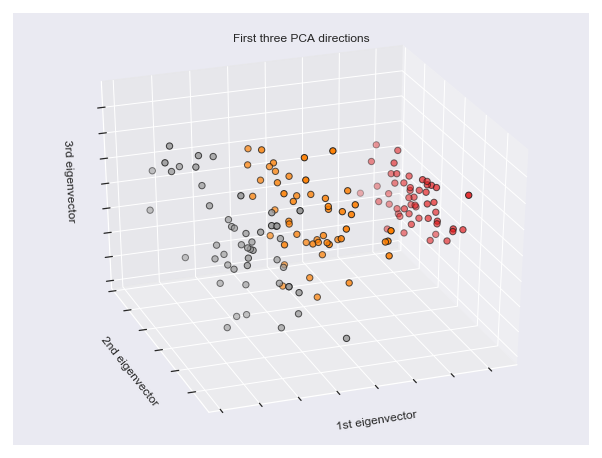

([], <a list of 0 Text yticklabel objects>)

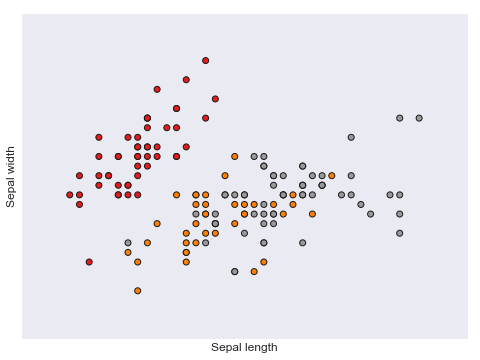

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target


# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()



## 2D plot (first two features)
X_ = iris.data[:, :2]  # we only take the first two features.
y = iris.target
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

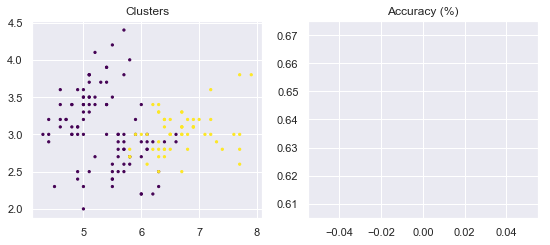

END: BELOW THRESHOLD
step: 8


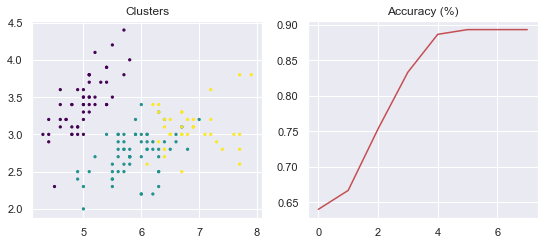

Accuracy Score 0.893333


In [29]:
rseed=random.randint(1,50)
centroids_regular, labels_regular, accuracy_regular = find_clusters_regular(X, n_clusters=3, threshold=0.01)
print("Accuracy Score %f"%(accuracy_score(y,labels_regular)))

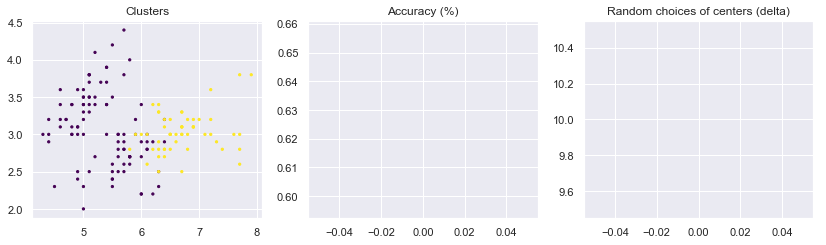

END: BELOW THRESHOLD
step: 7


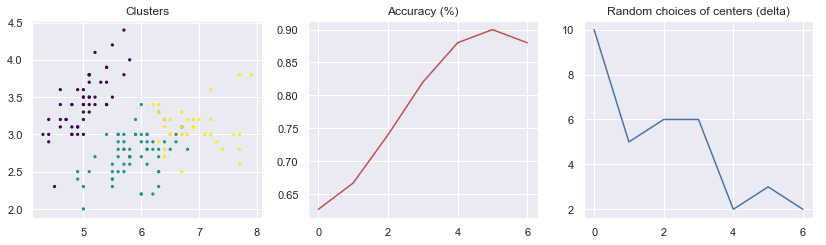

Accuracy Score 0.880000


In [30]:
centroids_delta, labels_delta, _, accuracy_delta = find_clusters_delta(X, n_clusters=3, delta=0.1, threshold=0.01)
print("Accuracy Score %f"%(accuracy_score(y,labels_delta)))

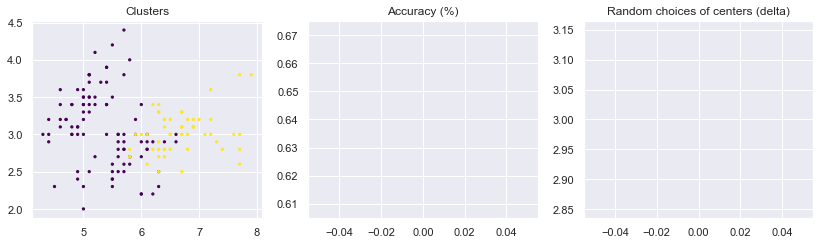

END: BELOW THRESHOLD
step: 8


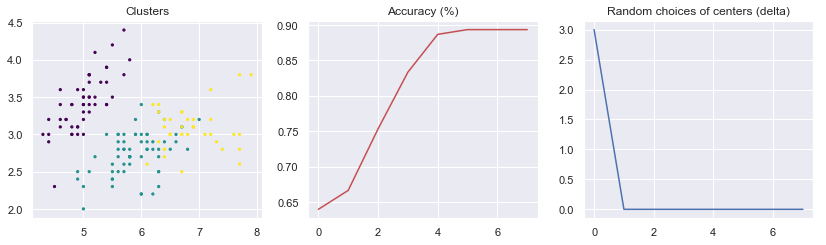

Accuracy Score 0.893333


In [31]:
centroids_delta2, labels_delta2, _, accuracy_delta2 = find_clusters_delta(X, n_clusters=3, delta=0.01, threshold=0.01)
print("Accuracy Score %f"%(accuracy_score(y,labels_delta2)))

rseed: 11
-----KMEANS-----


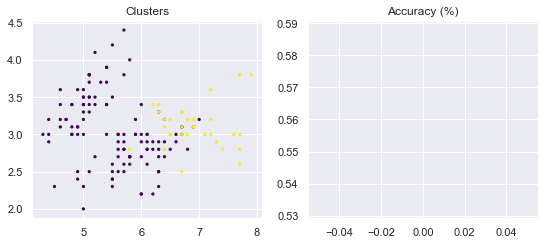

END: BELOW THRESHOLD
step: 8


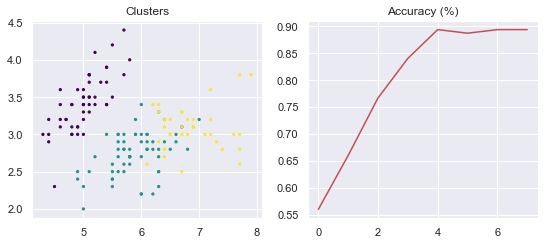

-----DMEANS: 0.001000-----


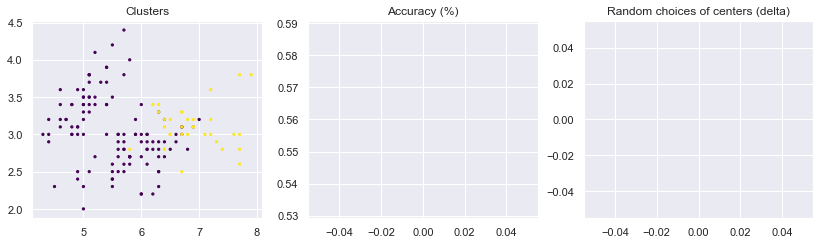

END: BELOW THRESHOLD
step: 8


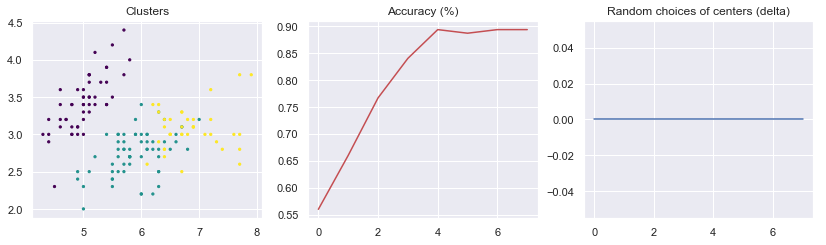

-----DMEANS: 0.005000-----


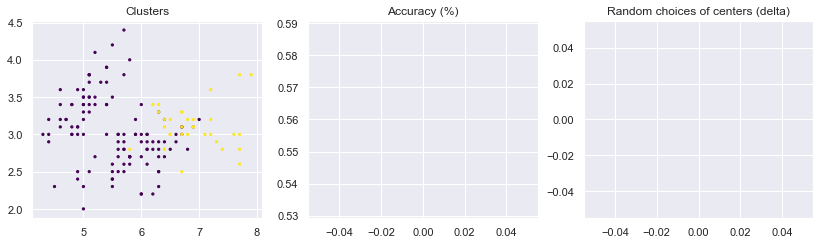

END: BELOW THRESHOLD
step: 8


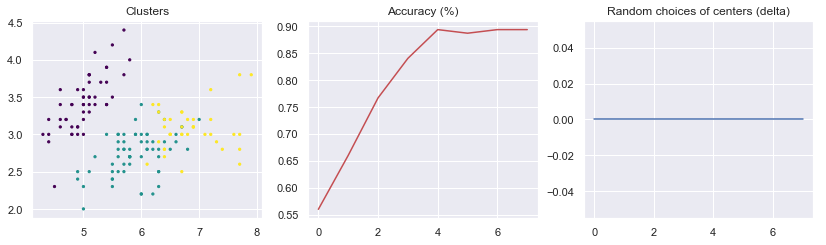

-----DMEANS: 0.010000-----


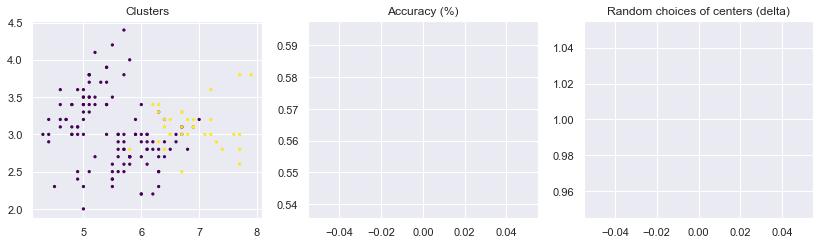

END: BELOW THRESHOLD
step: 8


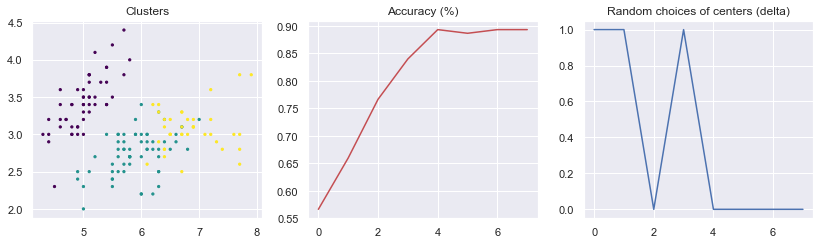

-----DMEANS: 0.025000-----


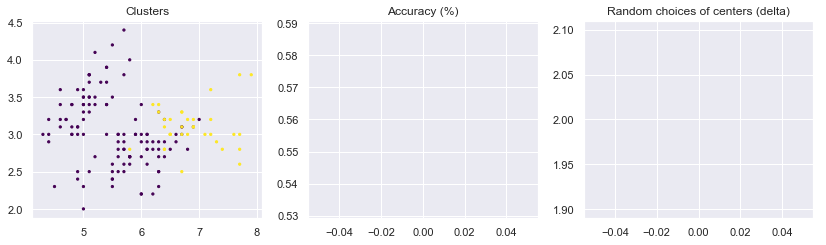

END: BELOW THRESHOLD
step: 8


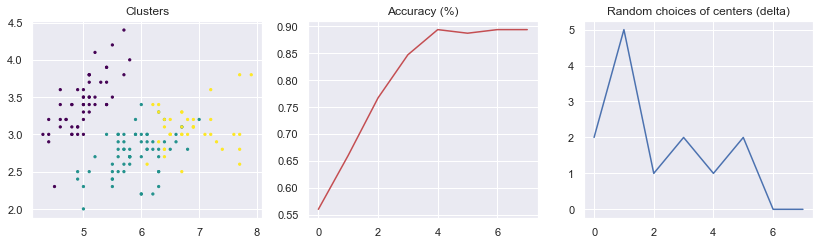

-----DMEANS: 0.050000-----


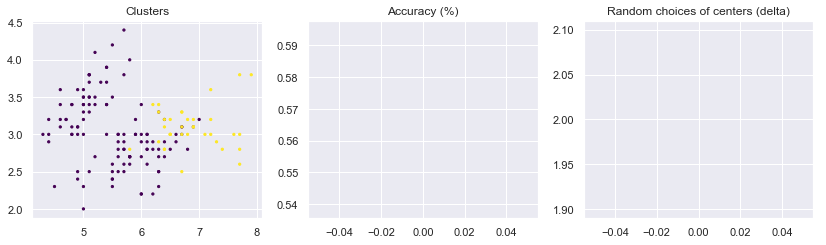

END: BELOW THRESHOLD
step: 8


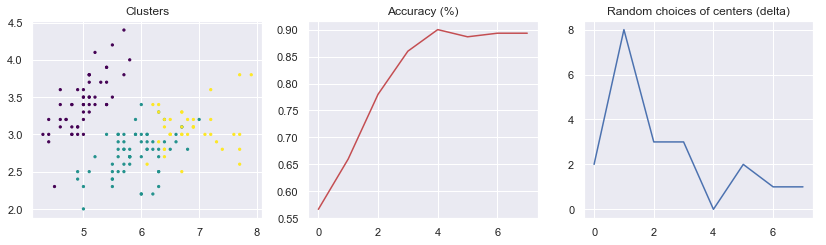

-----DMEANS: 0.100000-----


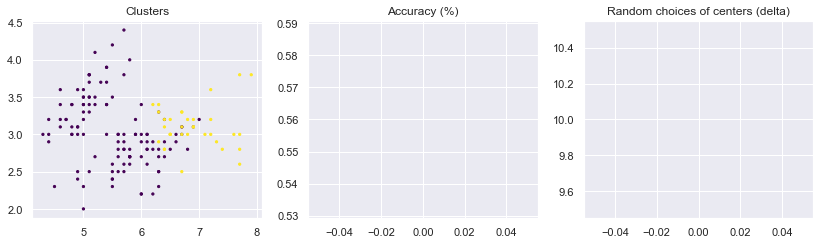

END: BELOW THRESHOLD
step: 7


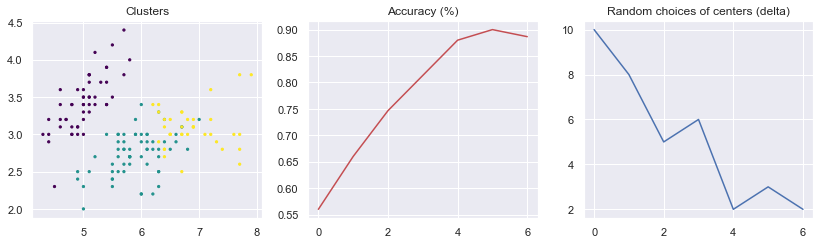

-----DMEANS: 0.250000-----


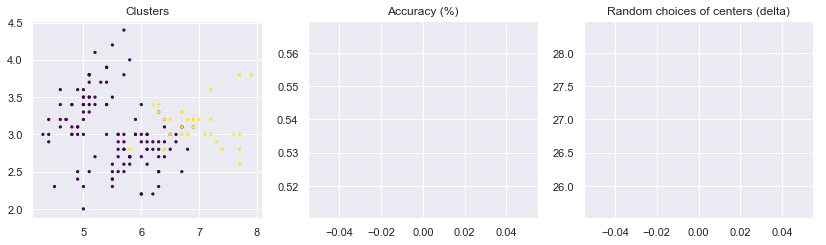

END: BELOW THRESHOLD
step: 7


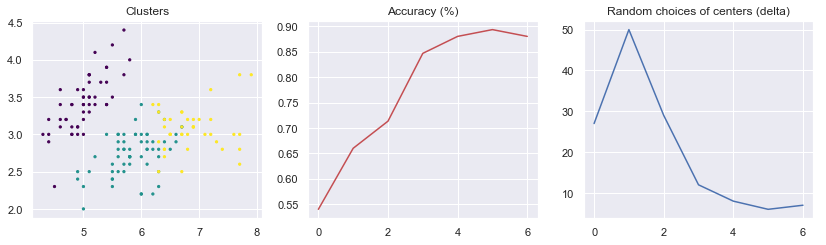

In [129]:
dataset = X
n_clusters = 3
rseed=random.randint(1,100)
print("rseed: "+str(rseed))

print("-----KMEANS-----")
_,_, accuracy_regular = find_clusters_regular(dataset, n_clusters, threshold=0.005)

deltas = [0.001,0.005,0.01,0.025,0.05,0.1,0.25]
accuracy_deltas = []
for delta in deltas:
    print("-----DMEANS: %f-----"%delta)
    _,_,_,accuracy = find_clusters_delta(dataset, n_clusters, delta=delta, threshold=0.005)
    accuracy_deltas.append(accuracy)

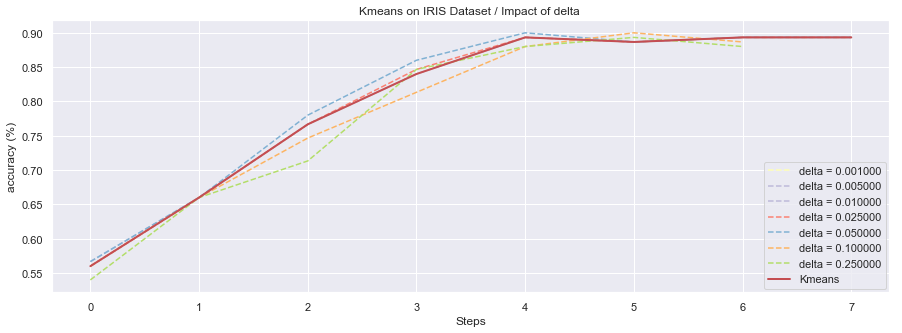

In [131]:
import matplotlib.cm as cm
#color = cm.Set3(np.random.rand(len(deltas)))
color = cm.Set3(np.linspace(0.1,0.5,len(deltas)))

plt.figure(figsize=(15,5))


for j in range(len(deltas)):
    delta_r = np.round(deltas[j],3)
    plt.plot(accuracy_deltas[j], c=color[j], label="delta = %f"%delta_r,linestyle='--',)
    
plt.plot(accuracy_regular, 'r',linewidth=2, label="Kmeans")



plt.title("Kmeans on IRIS Dataset / Impact of delta ")
plt.xlabel("Steps")
plt.ylabel("accuracy (%)")
plt.legend(bbox_to_anchor=(0.85, 0.48), loc=2, borderaxespad=0.)
plt.show()

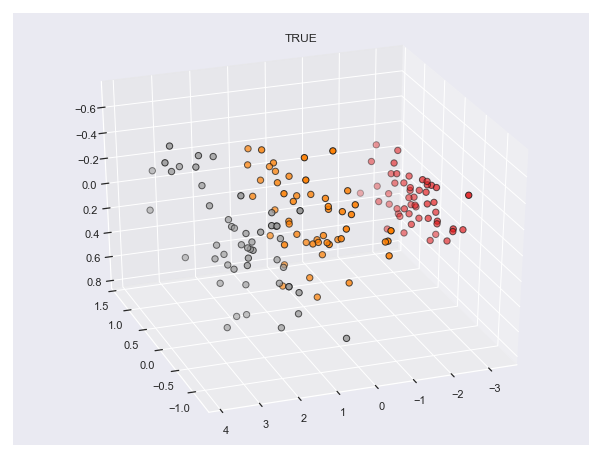

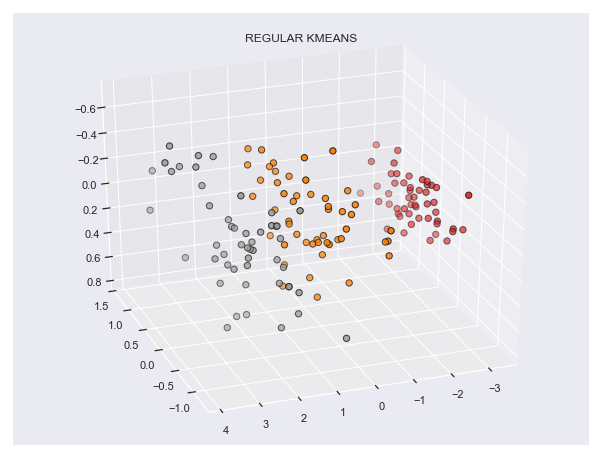

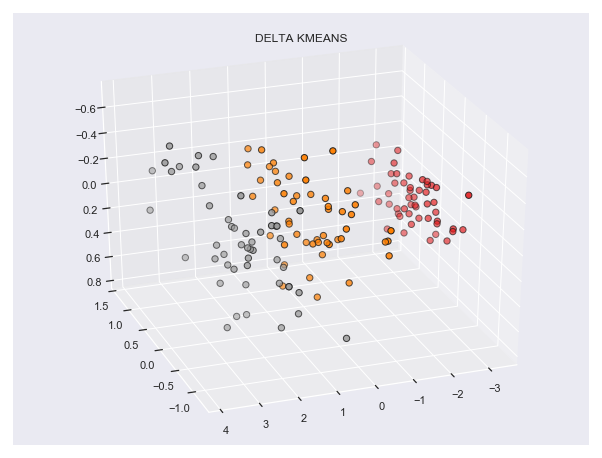

In [78]:
X_reduced = PCA(n_components=3).fit_transform(iris.data)
fig = plt.figure(1, figsize=(8, 6))
ax_true = Axes3D(fig, elev=-150, azim=110)
ax_true.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax_true.set_title("TRUE")
plt.show()

fig = plt.figure(1, figsize=(8, 6))
ax_regular = Axes3D(fig, elev=-150, azim=110)
ax_regular.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax_regular.set_title("REGULAR KMEANS")
plt.show()

fig = plt.figure(1, figsize=(8, 6))
ax_delta = Axes3D(fig, elev=-150, azim=110)
ax_delta.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax_delta.set_title("DELTA KMEANS")
plt.show()

In [ ]:
iterations_set = np.linspace(1, 30, num=1)
results_kmeans = []
results_dmeans = []
results_dmeans_2 = []
threshold = 0.000001 #useless
delta = 0.3
delta_2 = 1
n_clusters = 10

for iterations in iterations_set:
    print("Iteration %d "%iterations)
    
    accuracy_set_kmeans = []
    accuracy_set_dmeans = []
    accuracy_set_dmeans_2 = []
    
    for sample in range(3):
        print("sample: %d"%(sample))
        rseed=random.randint(10,50) #random initialization must be the same for comparing regular and delta kmeans
        
        #KMEANS
        print("kmeans")
        centroids_regular, labels_regular_ = find_clusters_regular(X, n_clusters, threshold, iterations=iterations)
        
        labels_regular = np.zeros_like(y)
        for i in range(10):
            mask = (labels_regular_ == i)
            labels_regular[mask] = mode(y[mask])[0]
        
        accuracy_set_kmeans.append(accuracy_score(y,labels_regular))
        
        
        #DMEANS
        print("Dmeans")
        centroids_delta, labels_delta_, _ = find_clusters_delta(X, n_clusters, delta, threshold, iterations=iterations)
        labels_delta = np.zeros_like(y)
        for i in range(10):
            mask = (labels_delta_ == i)
            labels_delta[mask] = mode(y[mask])[0]
        
        accuracy_set_dmeans.append(accuracy_score(y,labels_delta))  
        
        
        # DMEANS 2
        print("Dmeans_2")
        centroids_delta_2, labels_delta_2_, _ = find_clusters_delta(X, n_clusters, delta_2, threshold, iterations=iterations)
        labels_delta_2 = np.zeros_like(y)
        for i in range(10):
            mask = (labels_delta_2_ == i)
            labels_delta_2[mask] = mode(y[mask])[0]
        
        accuracy_set_dmeans_2.append(accuracy_score(y,labels_delta_2))        
        
        print("max_iter {}, execution {}, accuracy-kmeans = {:.2%} - accuracy-dmeans = {:.2%} - accuracy-dmeans_2 = {:.2%}".format(iterations, sample, accuracy_score(y,labels_regular), accuracy_score(y,labels_delta),accuracy_score(y,labels_delta_2)))    
                #if i==0:
        #    fig = plt.figure(figsize=(14, 8))
        #    ax1 = fig.add_subplot(231)
        #    ax1.scatter(X[:, 0], X[:, 1], c=labels_regular,
        #        s=5, cmap='viridis');
        #    ax1.set_title("KMEANS")
            
        #    ax2 = fig.add_subplot(232)
        #    ax2.scatter(X[:, 0], X[:, 1], c=labels_delta,
        #        s=5, cmap='viridis');
        #    ax2.set_title("DMEANS")
        #    plt.show() 
    #import pdb
    #pdb.set_trace()
    results_kmeans.append(np.average(accuracy_set_kmeans))
    results_dmeans.append(np.average(accuracy_set_dmeans))
    results_dmeans_2.append(np.average(accuracy_set_dmeans_2))
    
    print("max_iter = {} | kmeans avg accuracy: {:.2%} | dmeans avg accuracy: {:.2%} | dmeans_2 avg accuracy: {:.2%}".format(iterations, np.average(accuracy_set_kmeans),np.average(accuracy_set_dmeans),np.average(accuracy_set_dmeans_2)))

print(len(iterations_set))
print(len(results_kmeans))
print(len(results_dmeans))
print(len(results_dmeans_2))

print(iterations_set,results_kmeans, results_dmeans, results_dmeans_2)
import matplotlib.lines as mlines

plot_k = plt.plot(iterations_set,results_kmeans,'b', label="kmeans")
plot_d = plt.plot(iterations_set,results_dmeans,'r', label="dmeans")
plot_d_2 = plt.plot(iterations_set,results_dmeans_2,'y', label="dmeans_2")

blue_line = mlines.Line2D(iterations_set, results_kmeans, color='blue', marker='*', markersize=15, label='Kmeans')
red_line = mlines.Line2D(iterations_set, results_dmeans, color='red', marker='*', markersize=15, label='Dmeans  0.3')
yellow_line = mlines.Line2D(iterations_set, results_dmeans_2, color='yellow', marker='.', markersize=15, label='Dmeans 0.5')

plt.xlabel('Iterations ')
plt.ylabel('Accuracy (%)')


plt.xlim(0, 37)
plt.ylim(0.2, 1)
plt.grid(True)

plt.legend(handles=[blue_line, red_line, yellow_line]) #, labels=['kmeans', 'dmeans'])